In [27]:
import xgboost as xgb
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [13]:
%run ../risk_estimator/config.py

config = get_config()

In [14]:
%run ../risk_estimator/data_loader.py

dir = config['split_dir']
target = config['vol_target_col_name']

print("Loading test data...")
X_test, y_test = get_data(dir, 'test', target)  # Load the test data

Loading test data...


In [9]:
model = xgb.XGBRegressor()
model.load_model(config['vol_model_path'])  # Load the trained model
y_pred = model.predict(X_test)

MAE: 0.0008545702619193703, RMSE: 0.0012782056384482506, R2: -6.7576239497485195
Mean of y_test: 0.00019637772903705292, Std of y_test: 0.0004589193838523811


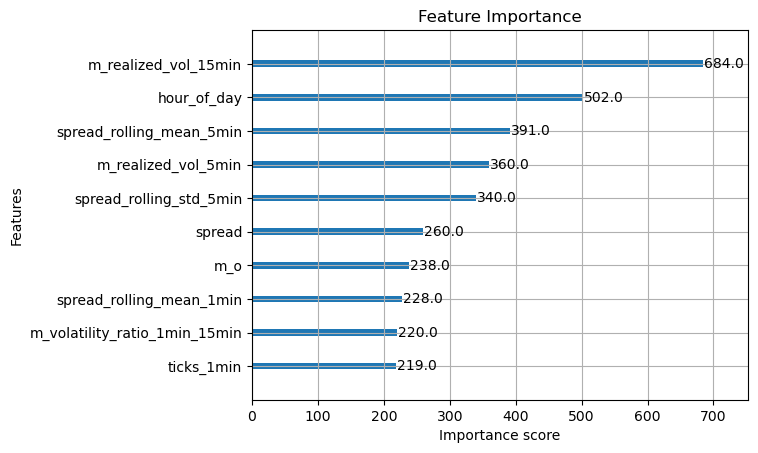

In [28]:

def report_feature_importance_and_metrics():
    xgb.plot_importance(model, max_num_features=10, title=f'Feature Importance')
    # Out-of-sample evaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    r2 = r2_score(y_test, y_pred)
    print(f"MAE: {mae}, RMSE: {rmse}, R2: {r2}")
    print(f"Mean of y_test: {y_test.mean()}, Std of y_test: {y_test.std()}")

report_feature_importance_and_metrics()

# Conclusion: The realized volatility forecast is worse than just predicting the mean (negative R2 score).


/Users/janul/Python/FX/expert-sniffle-public/risk_estimator/plotting.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby('bin').agg(
/Users/janul/Python/FX/expert-sniffle-public/risk_estimator/plotting.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg['mean_pred_for_bin'] = df.groupby('bin')['y_pred_for_bin'].mean().values


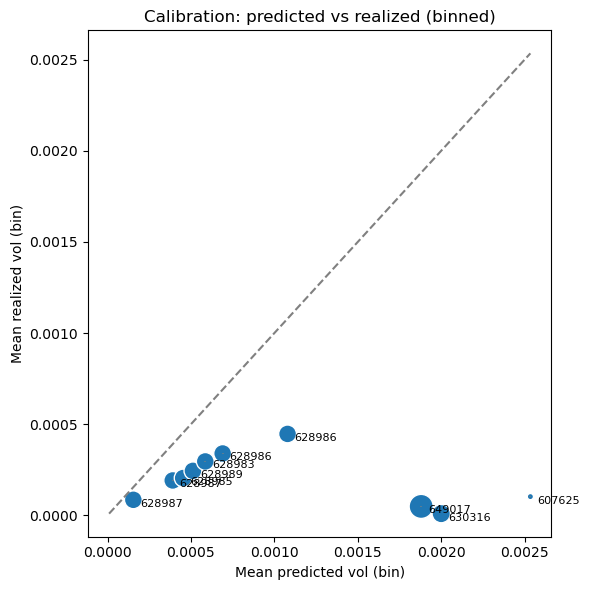

In [11]:
%run ../risk_estimator/plotting.py
agg = calibration_by_bins(y_test, y_pred, n_bins=10, method='quantile', log_transform=True)
fig, ax = plot_calibration(agg)
plt.show()

In [ ]:
# X_test.describe()
col0 = config['vol_source_col_name']
col1 = config['vol_target_col_name']
N = 100000
df = X_test[N:N+600:60]
df[col1] = y_test[N:N+600:60].values
# Print the source and target columns for the first 10 rows in a tabular format:

print(df[[col0, col1]])

# Conclusions: the 'future' data have been shifted correctly.

                           m_realized_vol_5min  m_realized_vol_5min_future
2015-01-06 18:53:20+00:00             0.000000                    0.000028
2015-01-06 18:58:20+00:00             0.000028                    0.000026
2015-01-06 19:03:20+00:00             0.000026                    0.000000
2015-01-06 19:08:20+00:00             0.000000                    0.000030
2015-01-06 19:13:20+00:00             0.000030                    0.000000
2015-01-06 19:18:20+00:00             0.000000                    0.000000
2015-01-06 19:23:20+00:00             0.000000                    0.000012
2015-01-06 19:28:20+00:00             0.000012                    0.000019
2015-01-06 19:33:20+00:00             0.000019                    0.000012
2015-01-06 19:38:20+00:00             0.000012                    0.000000


/var/folders/_w/p5pct1x578sdh9d614k94l_80000gs/T/ipykernel_43356/4136244579.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1] = y_test[N:N+600:60].values


In [ ]:
print(f"model's r2score: {r2_score(y_test, y_pred)}")
y_naive_persistence = X_test[[col0]]
print(f"naive persistence baseline r2score: {r2_score(y_test, y_naive_persistence)}")

# Conclusions: the model is worse than the naive persistence baseline.
# Advice taken: don’t force VaR validation on top of a weak volatility model.

model's r2score: -6.7576239497485195
naive persistence baseline r2score: -0.48269583030172725
